## Reading the data

In [1]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt

df = pd.read_csv("../../corpus_sprint2_imbalanced_cp.csv", encoding="utf-8")
df = df.dropna()

model = Doc2Vec.load("../../model_doc2vec_imbalanced_20epochs")

## One hot encoding and concatenating

In [2]:
vectors = model.docvecs.vectors_docs

In [3]:
#print(df)
one_hot = pd.Categorical(df['Product'])
df_dummies = pd.get_dummies(one_hot)

v_df = pd.DataFrame(vectors)
df_concat = pd.concat([v_df, df_dummies], axis = 1)
print(df_concat)

               0         1         2         3         4         5         6  \
0      -0.161180 -0.289027  1.038085  0.156838 -0.149066  0.072909 -0.055598   
1      -0.422184 -0.138897  0.348897  0.365505 -0.107822  0.319759 -0.186586   
2      -0.411936  0.273535  0.539075  0.243378  0.138218  0.147152 -0.420036   
3      -0.143756  0.299675 -0.165417  0.305554 -0.539212 -0.048760 -0.430821   
4      -0.020999 -0.091366  0.218800 -0.031445 -0.096297  0.339838 -0.023567   
...          ...       ...       ...       ...       ...       ...       ...   
485695  0.006161  0.430685 -0.036368  0.066746 -0.288969 -0.196536 -0.528009   
485696 -0.055671  0.203090  0.409770  0.439898 -0.532340 -0.330933  0.648665   
485697 -0.508467  0.183646  0.314372  0.043173 -0.729781 -0.159365 -0.139001   
485698  0.041722  0.685075  0.720559  0.899626 -0.750936 -0.238653  0.013337   
485699  0.112553  0.219081  0.460289 -0.183527  0.033055  0.604448  0.360667   

               7         8         9  .

## Applying k-means

In [4]:
from sklearn.cluster import KMeans
from sklearn import metrics

### Visual with elbow

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


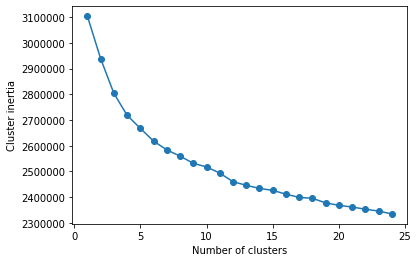

In [5]:
inertia = []
k_min=1
k_max=25
for i in range(k_min, k_max):
    print(i)
    km = KMeans(n_clusters=i,init='k-means++')
    km.fit(df_concat)
    inertia.append(km.inertia_)

plt.plot(range(k_min,k_max), inertia,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cluster inertia')
plt.show()

### Automatic with silhouette

For n_clusters = 11 The average silhouette_score is : 0.025877444
For n_clusters = 12 The average silhouette_score is : 0.026183693


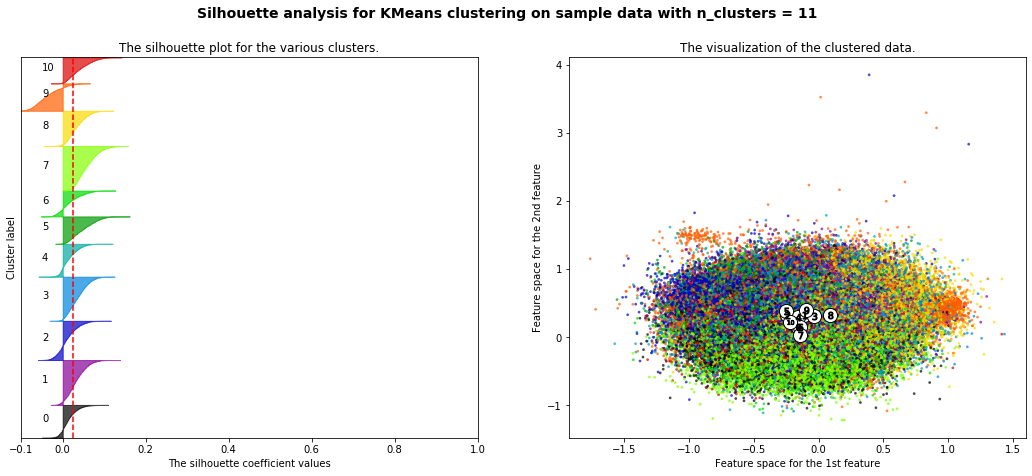

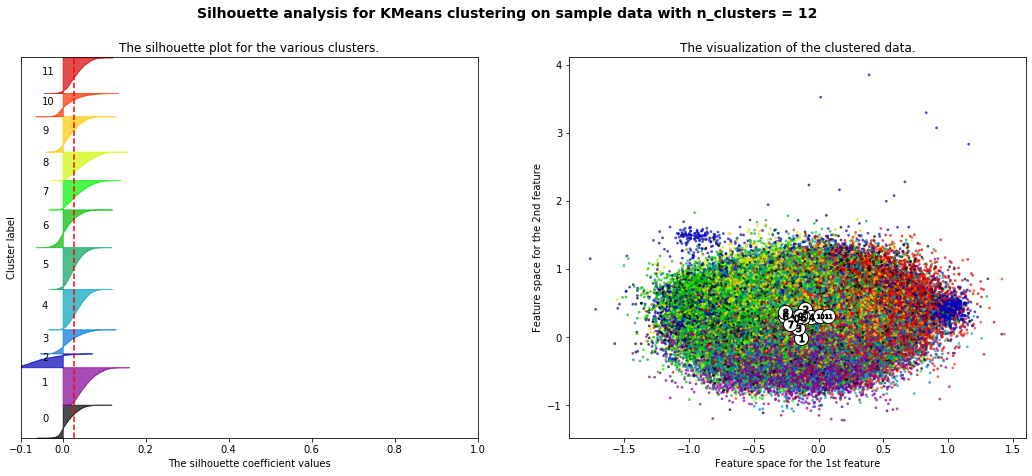

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [11, 12]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(vectors) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(vectors)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(vectors, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(vectors, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(vectors[:, 0], vectors[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()